# **ATLAS/ICESat-2 Land Ice Height Changes ATL11 Exploratory Data Analysis**

Adapted from https://github.com/suzanne64/ATL11/blob/master/intro_to_ATL11.ipynb

In [ ]:
import glob

import dask
import dask.array
import datashader
import geopandas as gpd
import holoviews as hv
import hvplot.dask
import hvplot.pandas
import hvplot.xarray
import intake
import matplotlib.cm
import numpy as np
import pandas as pd
import pygmt
import shapely
import xarray as xr

import deepicedrain

In [2]:
client = dask.distributed.Client(n_workers=32, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:33423 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 32 Cores: 32 Memory: 201.22 GB


# Load Data from Zarr

Let's start by getting our data and running some preprocessing steps:
- Load 1387 (reference ground tracks) ATL11/*.zarr files
- Convert coordinates from longitude/latitude to x/y
- Convert GPS delta_time to UTC time
- Mask out low quality height (h_corr) data

In [3]:
# Xarray open_dataset preprocessor to add fields based on input filename.
# Adapted from the intake.open_netcdf._add_path_to_ds function.
add_path_to_ds = lambda ds: ds.assign_coords(
    coords=intake.source.utils.reverse_format(
        format_string="ATL11.002z123/ATL11_{referencegroundtrack:04d}1x_{}_{}_{}.zarr",
        resolved_string=ds.encoding["source"],
    )
)

# Load dataset from all Zarr stores
# Aligning chunks spatially along cycle_number (i.e. time)
ds: xr.Dataset = xr.open_mfdataset(
    paths="ATL11.002z123/ATL11_*_002_01.zarr",
    chunks="auto",
    engine="zarr",
    combine="nested",
    concat_dim="ref_pt",
    parallel="True",
    preprocess=add_path_to_ds,
    backend_kwargs={"consolidated": True},
)
# ds = ds.unify_chunks().compute()
# TODO use intake, wait for https://github.com/intake/intake-xarray/issues/70
# source = intake.open_ndzarr(url="ATL11.002z123/ATL11_0*.zarr")

## Convert geographic lon/lat to x/y

To center our plot on the South Pole,
we'll reproject the original longitude/latitude coordinates
to the Antarctic Polar Stereographic (EPSG:3031) projection.

In [4]:
ds["x"], ds["y"] = deepicedrain.lonlat_to_xy(
    longitude=ds.longitude, latitude=ds.latitude
)

In [5]:
# Also set x/y as coordinates in xarray.Dataset instead of longitude/latitude
ds: xr.Dataset = ds.set_coords(names=["x", "y"])
ds: xr.Dataset = ds.reset_coords(names=["longitude", "latitude"])

## Convert delta_time to utc_time

To get more human-readable datetimes,
we'll convert the delta_time attribute from the original GPS time format
(nanoseconds since the beginning of ICESat-2 starting epoch)
to Coordinated Universal Time (UTC).
The reference date for the ICESat-2 Epoch is 2018 January 1st according to
https://github.com/SmithB/pointCollection/blob/master/is2_calendar.py#L11-L15

TODO: Account for [leap seconds](https://en.wikipedia.org/wiki/Leap_second)
in the future.

In [6]:
ds["utc_time"] = ds.delta_time.rename(new_name_or_name_dict="utc_time")
# ds["utc_time"] = deepicedrain.deltatime_to_utctime(dataarray=ds.delta_time)

## Mask out low quality height data

Good quality data has value 0, not so good is > 0.
Look at the 'fit_quality' attribute in `ds`
for more information on what this quality flag means.

We'll mask out values other than 0 with NaN using xarray's
[where](http://xarray.pydata.org/en/v0.15.1/indexing.html#masking-with-where).

In [7]:
ds["h_corr"] = ds.h_corr.where(cond=ds.fit_quality == 0)

## Subset to geographic region of interest (optional)

Take a geographical subset and save to a NetCDF/Zarr format for distribution.

In [8]:
# Antarctic bounding box locations with EPSG:3031 coordinates
regions = gpd.read_file(filename="deepicedrain/deepicedrain_regions.geojson")
regions: gpd.GeoDataFrame = regions.set_index(keys="placename")

# Subset to essential columns
essential_columns: list = [
    "x",
    "y",
    "utc_time",
    "h_corr",
    "longitude",
    "latitude",
    "delta_time",
    "cycle_number",
]

In [9]:
# Do the actual computation to find data points within region of interest
placename: str = "kamb"  # Select Kamb Ice Stream region
region: deepicedrain.Region = deepicedrain.Region.from_gdf(gdf=regions.loc[placename])
ds_subset: xr.Dataset = region.subset(data=ds)
ds_subset = ds_subset.unify_chunks()
ds_subset = ds_subset.compute()

In [10]:
# Save to Zarr/NetCDF formats for distribution
ds_subset.to_zarr(
    store=f"ATLXI/ds_subset_{placename}.zarr", mode="w", consolidated=True
)
ds_subset.to_netcdf(path=f"ATLXI/ds_subset_{placename}.nc", engine="h5netcdf")

In [11]:
# Look at Cycle Number 7 only for plotting
points_subset = hv.Points(
    data=ds_subset.sel(cycle_number=7)[[*essential_columns]],
    label="Cycle_7",
    kdims=["x", "y"],
    vdims=["utc_time", "h_corr", "cycle_number", "referencegroundtrack"],
    datatype=["xarray"],
)
df_subset = points_subset.dframe()

In [ ]:
# Plot our subset of points on an interactive map
df_subset.hvplot.points(
    title=f"Elevation (metres) at Cycle 7",
    x="x",
    y="y",
    c="referencegroundtrack",
    cmap="Set3",
    # rasterize=True,
    hover=True,
    datashade=True,
    dynspread=True,
)

# Pivot into a pandas/dask dataframe

To make data analysis and plotting easier,
let's flatten our n-dimensional `xarray.Dataset`
to a 2-dimensiontal `pandas.DataFrame` table format.

There are currently 8 cycles (as of July 2020),
and by selecting just one cycle at a time,
we can see what the height (`h_corr`)
of the ice is like at that time.

## Looking at ICESat-2 Cycle 7

In [13]:
cycle_number: int = 7
dss = ds.sel(cycle_number=cycle_number)[[*essential_columns]]
print(dss)

<xarray.Dataset>
Dimensions:               (ref_pt: 229035648)
Coordinates:
    x                     (ref_pt) float64 -1.748e+05 -1.748e+05 ... 8.298e+04
    y                     (ref_pt) float64 1.185e+06 1.185e+06 ... -1.197e+06
    delta_time            (ref_pt) timedelta64[ns] dask.array<chunksize=(26339,), meta=np.ndarray>
    cycle_number          int64 7
    referencegroundtrack  (ref_pt) int64 1 1 1 1 1 ... 1387 1387 1387 1387 1387
  * ref_pt                (ref_pt) int64 1565331 1565334 ... 1443582 1443585
Data variables:
    utc_time              (ref_pt) datetime64[ns] dask.array<chunksize=(26339,), meta=np.ndarray>
    h_corr                (ref_pt) float32 dask.array<chunksize=(52678,), meta=np.ndarray>
    longitude             (ref_pt) float64 dask.array<chunksize=(52678,), meta=np.ndarray>
    latitude              (ref_pt) float64 dask.array<chunksize=(52678,), meta=np.ndarray>
Attributes:
    ATL06_xover_field_list:   ['delta_time', 'h_li', 'h_li_sigma', 'latitude'.

In [14]:
points = hv.Points(
    data=dss,
    label=f"Cycle_{cycle_number}",
    kdims=["x", "y"],
    vdims=["utc_time", "h_corr", "cycle_number"],
    datatype=["xarray"],
)

In [15]:
df = points.dframe()  # convert to pandas.DataFrame, slow
df = df.dropna()  # drop empty rows
print(len(df))
df.head()

171089724


,x,y,utc_time,h_corr,cycle_number
0,-174761.761971,1.185317e+06,2020-03-26 15:32:15.957044095,2021.187378,7
1,-174781.279702,1.185372e+06,2020-03-26 15:32:15.964079395,2021.272949,7
2,-174800.797361,1.185428e+06,2020-03-26 15:32:15.972532213,2021.388062,7
3,-174820.314262,1.185483e+06,2020-03-26 15:32:15.980990678,2021.455933,7
4,-174839.832243,1.185538e+06,2020-03-26 15:32:15.989444897,2021.541260,7


### Plot a sample of the points over Antarctica

Let's take a look at an interactive map
of the ICESat-2 ATL11 height for Cycle 6!
We'll plot a random sample (n=5 million)
of the points instead of the whole dataset,
it should give a good enough picture.

In [ ]:
df.sample(n=5_000_000).hvplot.points(
    title=f"Elevation (metres) at Cycle {cycle_number}",
    x="x",
    y="y",
    c="h_corr",
    cmap="Blues",
    rasterize=True,
    hover=True,
)

# Calculate Elevation Change (dh) over ICESAT-2 cycles!!

Let's take a look at the change in elevation over a year (4 ICESat-2 cycles).
From our loaded dataset (ds), we'll select Cycles 3 and 7,
and subtract the height (h_corr) between them to get a height difference (dh).

In [17]:
dh: xr.DataArray = deepicedrain.calculate_delta(
    dataset=ds, oldcyclenum=3, newcyclenum=7, variable="h_corr"
)

In [18]:
# Persist data in memory
dh = dh.persist()

In [19]:
delta_h: xr.Dataset = dh.dropna(dim="ref_pt").to_dataset(name="delta_height")
print(delta_h)

<xarray.Dataset>
Dimensions:               (ref_pt: 136029524)
Coordinates:
  * ref_pt                (ref_pt) int64 1421511 1421514 ... 1443594 1443597
    referencegroundtrack  (ref_pt) int64 1 1 1 1 1 ... 1364 1364 1364 1364 1364
    x                     (ref_pt) float64 6.678e+05 6.677e+05 ... -1.495e+04
    y                     (ref_pt) float64 -1.481e+06 -1.481e+06 ... 1.199e+06
Data variables:
    delta_height          (ref_pt) float32 dask.array<chunksize=(45,), meta=np.ndarray>


In [20]:
df_dh: pd.DataFrame = delta_h.to_dataframe()
print(df_dh.head())

         referencegroundtrack              x             y  delta_height
ref_pt                                                                  
1421511                     1  667763.459799 -1.480881e+06     -0.219727
1421514                     1  667747.547896 -1.480824e+06     -0.194458
1421517                     1  667731.636741 -1.480767e+06     -0.521118
1421520                     1  667716.200759 -1.480710e+06     -0.485229
1421523                     1  667700.285641 -1.480653e+06     -0.337769


In [21]:
# Save or Load delta height data
# df_dh.to_parquet(f"ATLXI/df_dh_{placename}.parquet")
# df_dh: pd.DataFrame = pd.read_parquet(f"ATLXI/df_dh_{placename}.parquet")
# df_dh = df_dh.sample(n=1_000_000)

## Plot elevation difference for a region

Using [datashader](https://datashader.org) to make the plotting real fast,
it actually rasterizes the vector points into a raster grid,
since our eyes can't see millions of points that well anyway.
You can choose any region, but we'll focus on the Siple Coast Ice Streams.
Using [PyGMT](https://pygmt.org), we'll plot the Antarctic grounding line
as well as the ATL11 height changes overlaid with Subglacial Lake outlines
from [Smith et al., 2009](https://doi.org/10.3189/002214309789470879).

In [22]:
# Select region here, see also geodataframe of regions at top
placename: str = "antarctica"
region: deepicedrain.Region = deepicedrain.Region.from_gdf(gdf=regions.loc[placename])

In [23]:
# Find subglacial lakes (Smith et al., 2009) within region of interest
subglacial_lakes_gdf = gpd.read_file(
    filename=r"Quantarctica3/Glaciology/Subglacial Lakes/SubglacialLakes_Smith.shp"
)
subglacial_lakes_gdf = subglacial_lakes_gdf.loc[
    subglacial_lakes_gdf.within(
        shapely.geometry.Polygon.from_bounds(*region.bounds(style="lbrt"))
    )
]
subglacial_lakes_geom = [g for g in subglacial_lakes_gdf.geometry]
subglacial_lakes = [
    np.dstack(g.exterior.coords.xy).squeeze().astype(np.float32)
    for g in subglacial_lakes_geom
]

In [24]:
# Datashade our height values (vector points) onto a grid (raster image)
agg_grid: xr.DataArray = region.datashade(df=df_dh, z_dim="delta_height")
print(agg_grid)

<xarray.DataArray (y: 1145, x: 1400)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 -2.698e+06 -2.694e+06 -2.69e+06 ... 2.794e+06 2.798e+06
  * y        (y) float64 -2.198e+06 -2.194e+06 -2.19e+06 ... 2.294e+06 2.298e+06


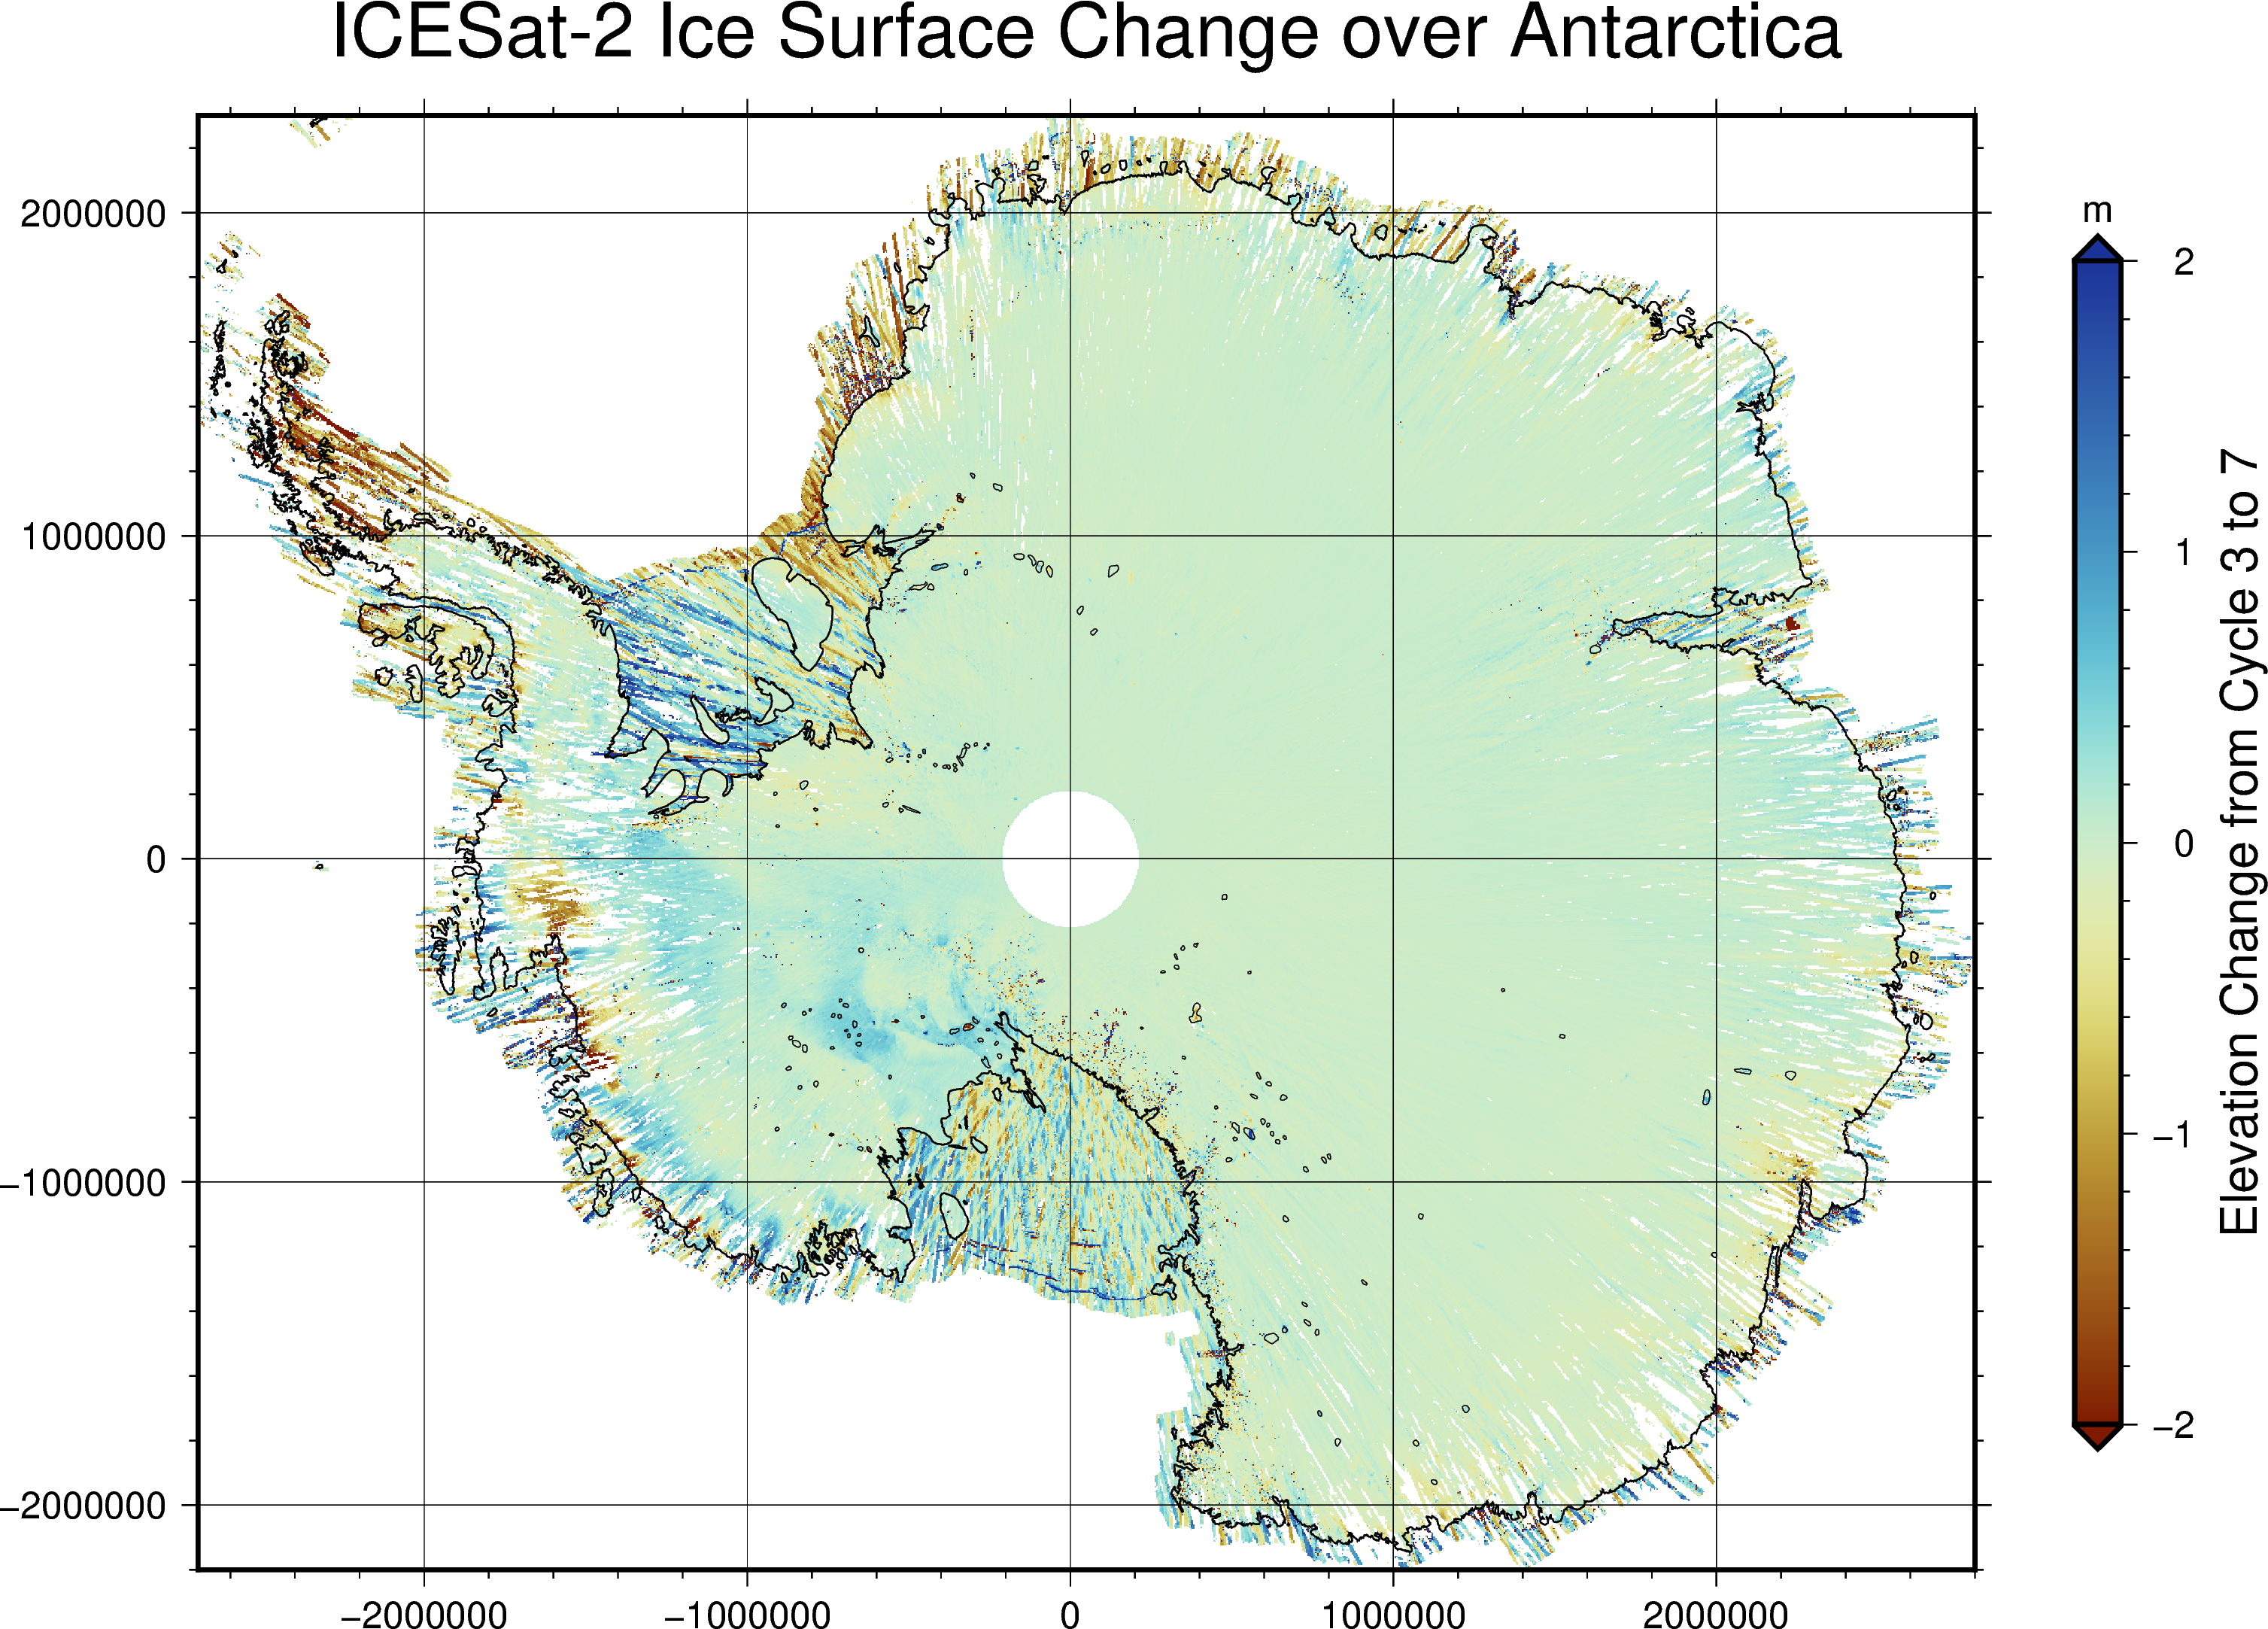

In [25]:
# Plot our map!
scale: int = region.scale
fig = pygmt.Figure()
# fig.grdimage(
#    grid="Quantarctica3/SatelliteImagery/MODIS/MODIS_Mosaic.tif",
#    region=region,
#    projection=f"x{scale}",
#    I="+d",
# )
pygmt.makecpt(cmap="roma", series=[-2, 2])
fig.grdimage(
    grid=agg_grid,
    region=region.bounds(),
    projection=f"x1:{scale}",
    frame=["afg", f'WSne+t"ICESat-2 Ice Surface Change over {region.name}"'],
    Q=True,
)
for subglacial_lake in subglacial_lakes:
    fig.plot(data=subglacial_lake, L=True, pen="thinnest")
fig.colorbar(
    position="JCR+e", frame=["af", 'x+l"Elevation Change from Cycle 3 to 7"', "y+lm"]
)
fig.coast(
    region=region.bounds(),
    projection=f"s0/-90/-71/1:{scale}",
    area_thresh="+ag",
    resolution="i",
    shorelines="0.5p",
    # land="snow4",
    # water="snow3",
    V="q",
)
fig.savefig(f"figures/plot_atl11_dh37_{placename}.png")
fig.show(width=600)

#### Non-PyGMT plotting code on PyViz stack

Meant to be a bit more interactive but slightly buggy,
need to sort out python dependency issues.

In [ ]:
shade_grid = datashader.transfer_functions.shade(
    agg=agg_grid, cmap=matplotlib.cm.RdYlBu, how="linear", span=[-2, 2]
)
spread_grid = datashader.transfer_functions.dynspread(shade_grid)
spread_grid

In [ ]:
df_dh.hvplot.points(
    # title="Elevation Change (metres) from Cycle 5 to 6",
    x="x",
    y="y",
    c="delta_height",
    # cmap="RdYlBu",
    # aggregator=datashader.mean("delta_height"),
    rasterize=True,
    # responsive=True,
    # datashade=True,
    # dynamic=True,
    # dynspread=True,
    hover=True,
    height=400,
    symmetric=True,
    clim=(-20, 20),
)

In [ ]:
points = hv.Points(
    data=df_dh,
    kdims=["x", "y"],
    vdims=["delta_height"],
    # datatype=["xarray"],
)

In [ ]:
hv.operation.datashader.datashade(points)